In [485]:
import numpy as np
import yfinance as yf
import math
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [486]:
df = yf.download('AAPL', start='2015-01-01', end='2025-01-06')
df.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in df.columns]
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']


df


[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,24.347166,27.332500,27.860001,26.837500,27.847500,212818400
2015-01-05,23.661274,26.562500,27.162500,26.352501,27.072500,257142000
2015-01-06,23.663496,26.565001,26.857500,26.157499,26.635000,263188400
2015-01-07,23.995314,26.937500,27.049999,26.674999,26.799999,160423600
2015-01-08,24.917265,27.972500,28.037500,27.174999,27.307501,237458000
...,...,...,...,...,...,...
2024-12-27,255.589996,255.589996,258.700012,253.059998,257.829987,42355300
2024-12-30,252.199997,252.199997,253.500000,250.750000,252.229996,35557500
2024-12-31,250.419998,250.419998,253.279999,249.429993,252.440002,39480700


In [487]:
df.shape

(2518, 6)

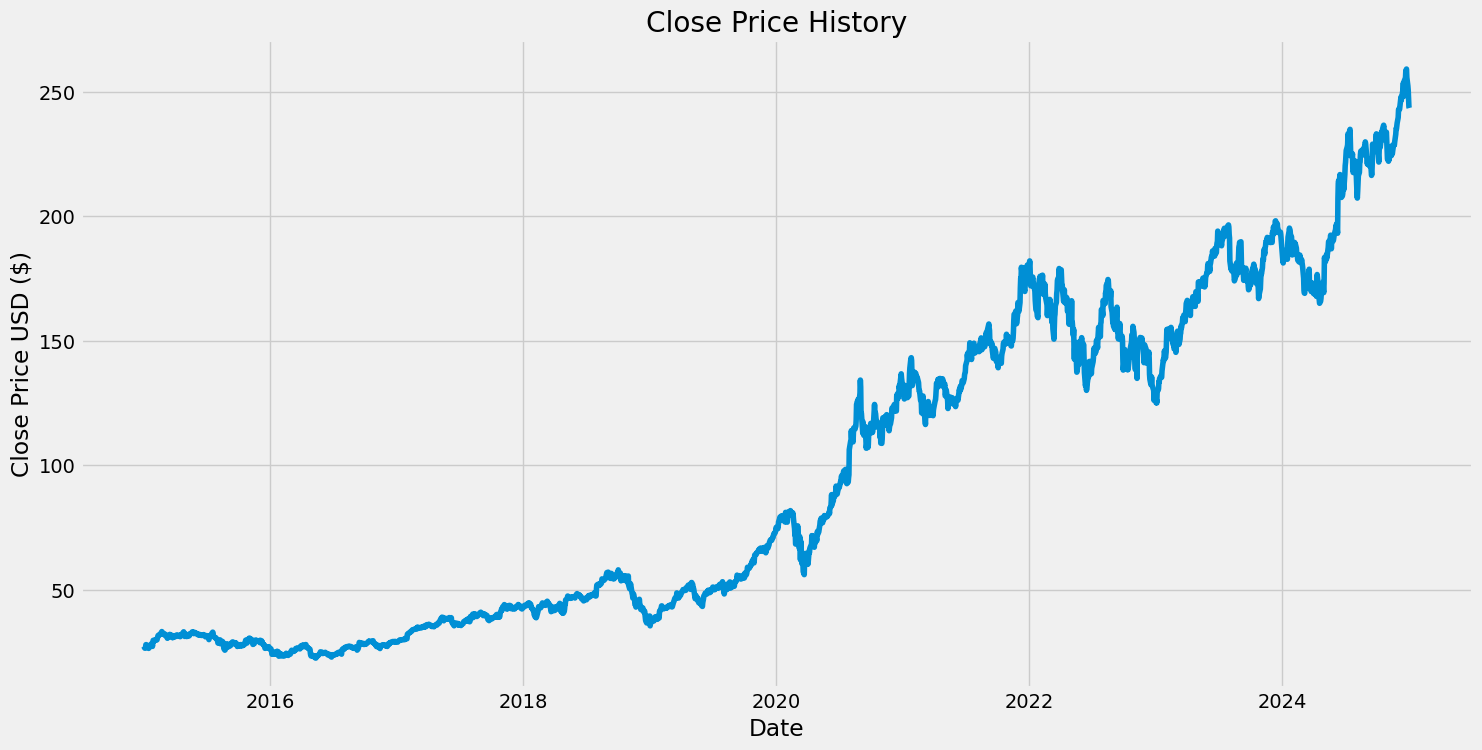

In [488]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

In [489]:
data = df.filter(['Close'])
dataset = data.values

In [490]:
dataset

array([[ 27.33250046],
       [ 26.5625    ],
       [ 26.56500053],
       ...,
       [250.41999817],
       [243.8500061 ],
       [243.36000061]])

In [491]:
len(dataset)

2518

In [492]:
train = dataset[0:math.ceil(len(dataset)*0.8)]
test = dataset[math.ceil(len(dataset)*0.8):]

In [493]:
print(len(train))
print(len(test))

2015
503


In [494]:
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train.reshape(-1,1))
test_scaled = scaler.transform(test.reshape(-1,1))

In [495]:
train_scaled

array([[0.0297789 ],
       [0.02494904],
       [0.02496473],
       ...,
       [0.67131883],
       [0.67332599],
       [0.64284148]])

#In time series forecasting, the lookback window (or timesteps) refers to the number of previous time steps used to predict the next value

In [496]:
lookback = 60

X_train, y_train = [], []
for i in range(lookback, len(train_scaled)):
    X_train.append(train_scaled[i-lookback:i,0])  # Previous 'lookback' values
    y_train.append(train_scaled[i])            # Next value to predict

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (1955, 60)
y_train shape: (1955, 1)


WHAT DOES THESE SHAPES MEANS ?
The target y is predicted using the last 60 days

Note that we need the Xtrain to be 3d array, because its the format required by LSTM

In [497]:
# Create the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(lookback, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [498]:
model.compile(optimizer='adam', loss='mean_squared_error')

the compile() method configures the LSTM model for training. It defines:

Optimizer: Algorithm to adjust model weights to minimize the loss.

Loss Function: Measures how far predictions are from actual values.

In [499]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

1955/1955 ━━━━━━━━━━━━━━━━━━━━ 60s 29ms/step - loss: 0.0037


Creating the test dataset

In [500]:
lookback = 60

X_test, y_test = [], []
for i in range(lookback, len(test_scaled)):
    X_test.append(test_scaled[i-lookback:i,0])
    y_test.append(test_scaled[i])

In [501]:
X_test, y_test = np.array(X_test), np.array(y_test)


In [502]:
print(X_test.shape)
print(y_test.shape)

(443, 60)
(443, 1)


In [503]:
scaled_predictions = model.predict(X_test)
prediction = scaler.inverse_transform(scaled_predictions)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


In [504]:
#evaluate the model using RMSE
y_test_original = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean(prediction - y_test_original)**2)

In [505]:
RMSE


11.116599916066328

In [524]:
train = data[:math.ceil(len(dataset)*0.8)]
valid = data[math.ceil(len(dataset)*0.8):]
valid = valid[lookback:]
valid['Predictions'] = prediction

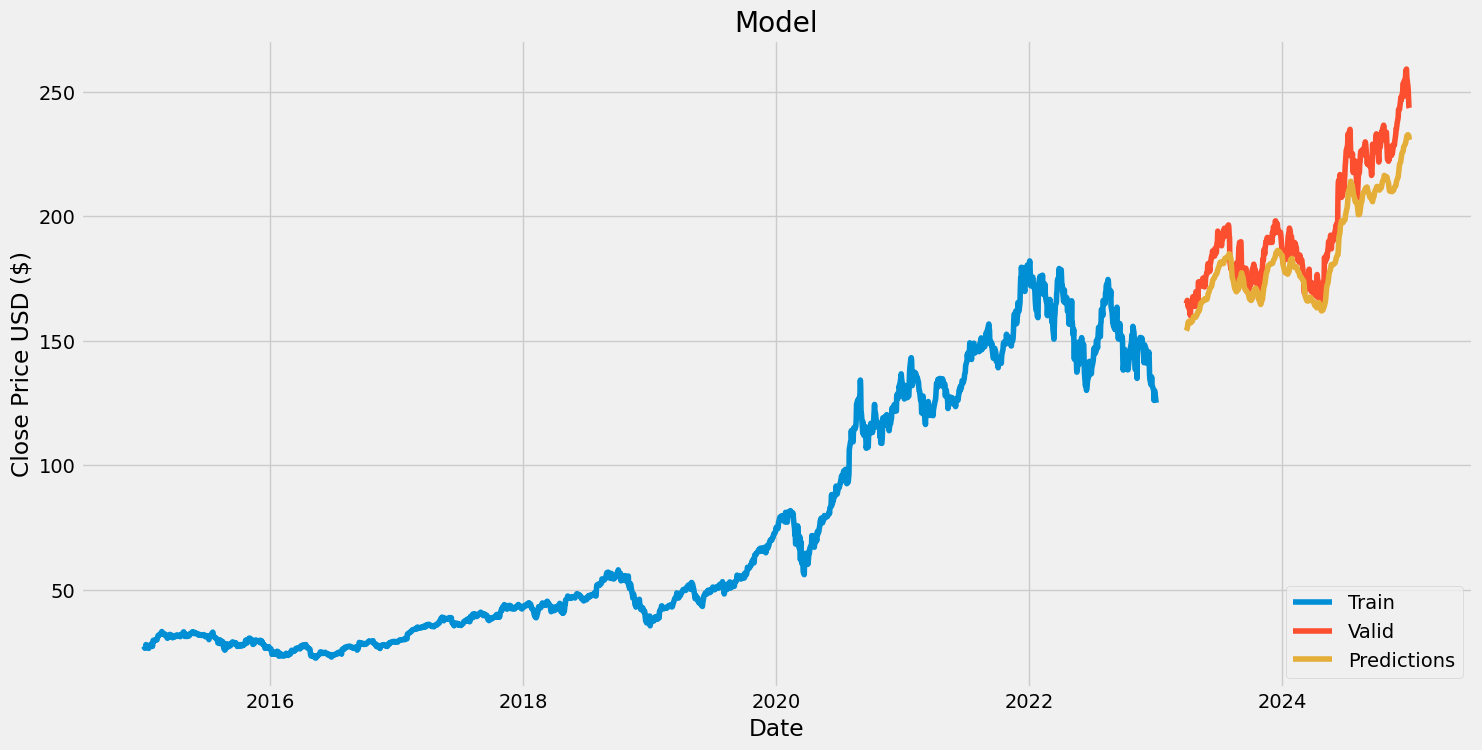

In [578]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [526]:
valid

,Close,Predictions
Date,,
2023-03-31,164.899994,154.033081
2023-04-03,166.169998,154.969284
2023-04-04,165.630005,156.049286
2023-04-05,163.759995,156.982269
2023-04-06,164.660004,157.518784
...,...,...
2024-12-27,255.589996,232.141953
2024-12-30,252.199997,232.672348
2024-12-31,250.419998,232.550629


In [529]:
X_test

array([[0.65093307, 0.64252784, 0.67138152, ..., 0.84720087, 0.86677127,
        0.87674459],
       [0.64252784, 0.67138152, 0.67470596, ..., 0.86677127, 0.87674459,
        0.8926768 ],
       [0.67138152, 0.67470596, 0.67834405, ..., 0.87674459, 0.8926768 ,
        0.90064296],
       ...,
       [1.28094722, 1.24889452, 1.2744865 , ..., 1.48304843, 1.46153366,
        1.44026975],
       [1.24889452, 1.2744865 , 1.29813392, ..., 1.46153366, 1.44026975,
        1.42910463],
       [1.2744865 , 1.29813392, 1.29499765, ..., 1.44026975, 1.42910463,
        1.38789408]])

In [591]:

#the model will predict the prices for the day after the end date, it need the past 60 days prices to predict the next day price, so it can't predict prices after one months
def predict_stock_price(start_date, end_date):
    lookback=60
    df = yf.download('AAPL', start_date, end_date)
    df.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in df.columns]
    df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    data = df.filter(['Close'])
    dataset = data.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_len = math.ceil(len(dataset) * 0.8)
    train_data = dataset[0:train_data_len]
    test_data = dataset[train_data_len:]
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))
    X_train, y_train = [], []
    for i in range(lookback, len(train_scaled)):
        X_train.append(train_scaled[i - lookback:i, 0])
        y_train.append(train_scaled[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test, y_test = [], []
    for i in range(lookback, len(test_scaled)):
        X_test.append(test_scaled[i-lookback:i,0])
        y_test.append(test_scaled[i])
    X_test, y_test = np.array(X_test), np.array(y_test)
    scaled_predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(scaled_predictions)
    return predictions[-1][0]
predict_stock_price('2015-01-01', '2025-01-04')

[*********************100%***********************]  1 of 1 completed


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


230.62561